In [1]:
SAVE = True

VERSION = 'Empirical Covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

In [2]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
from feature_names import INTERACTIVE_NAMES, INTERVENTION_NAMES_EN
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]

Aggregation functions for ATT results

In [38]:
import numpy as np
from scipy import stats
import pandas as pd

def weighted_group_test(att_df, att_col="att_i", weight_col="n_treated"):
    """
    Compute weighted mean ATT and t-test vs 0 across participants.

    att_df: DataFrame with columns [att_col, weight_col]
        att_col = participant-level ATT
        weight_col = number of treated intervals (or chosen weights)

    Returns: dict with mean, se, ci95_low, ci95_high, t, p, N_eff, N
    """
    df = att_df.dropna(subset=[att_col, weight_col]).copy()
    w = df[weight_col].to_numpy(dtype=float)
    x = df[att_col].to_numpy(dtype=float)
    if len(x) < 2:
        return {"mean": np.nan, "se": np.nan, "ci95_low": np.nan,
                "ci95_high": np.nan, "t": np.nan, "p": np.nan,
                "N": len(x), "N_eff": np.nan}
    # Weighted mean
    mean_w = np.sum(w * x) / np.sum(w)
    # Weighted variance (between-person)
    var_w = np.sum(w * (x - mean_w)**2) / np.sum(w)
    # Effective N (Kish)
    N_eff = (np.sum(w)**2) / np.sum(w**2)
    se_w = np.sqrt(var_w / N_eff)
    t_stat = mean_w / se_w if se_w > 0 else np.nan
    dfree = N_eff - 1
    p_val = 2 * stats.t.sf(np.abs(t_stat), df=dfree)
    ci_low = mean_w - 1.96 * se_w
    ci_high = mean_w + 1.96 * se_w
    return pd.Series({
        "mean": mean_w, "se": se_w,
        "ci95_low": ci_low, "ci95_high": ci_high,
        "t": t_stat, "p": p_val,
        "N": len(x), "N_eff": N_eff
    })
def groupwise_att(df: pd.DataFrame, values_col: str, weights_col: str):
    weighted_mean = np.average(df[values_col], axis=0, weights=df[weights_col])
    p_value = stats.ttest_1samp(df[values_col].astype('float'), 0, alternative='greater').pvalue
    return pd.Series({'mean': weighted_mean, 'p_value': p_value})

Calculate PLRNN CIRs

In [39]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from bptt.plrnn import PLRNN
from comparison_models.simple_models.models import KalmanFilter, VAR1

MRT = [2, 3]
plrnn_emi_cir = []
errors_loading_model = 0
ModelClass = PLRNN

for mrt in MRT:

    mrt_cir = []

    results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_every_day_x6')
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')

    models = eval_reallabor_utils.ModelCatalogue(results_dir)
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating Impulse Responses for MRT {mrt}'):            
        model_dirs = models.get_latest_model_dirs(p)
        participant_cir = []
        for model_dir in model_dirs:
            model_cir = []
            args = utils.load_args(model_dir)
            model = ModelClass(args)
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            dim_x, dim_s = args['dim_x'], args['dim_s']
            
            x0 = tc.tensor(df[LABELS].to_numpy()).float()
            cir = tc.zeros(dim_s)
            for i in range(dim_s):
                perturbation = tc.zeros(dim_s).float()
                perturbation[i] = 1
                cir[i] = tc.nanmean(eval_reallabor_utils.impulse_response(model, perturbation, 1, cumulative=True, relative=True, x0=x0, Gamma=Gamma, B=B))
            model_cir = pd.Series(cir.detach().numpy(), index=INTERACTIVE_NAMES)
            participant_cir.append(model_cir)
        if len(participant_cir) == 0:
            continue
        participant_cir_df = pd.concat(participant_cir, axis=1).T.mean(numeric_only=True)
        participant_cir_df['participant'] = int(p)
        mrt_cir.append(participant_cir_df)
    mrt_cir = pd.concat(mrt_cir, axis=1).T.set_index('participant')
    plrnn_emi_cir.append(mrt_cir)
plrnn_emi_cir = pd.concat(plrnn_emi_cir, axis=0, keys=MRT, names=['MRT']).sort_index()

if errors_loading_model > 0:
    print(f"Warning: {errors_loading_model} errors loading Gamma and B.")

Calculating Impulse Responses for MRT 3: 100%|██████████| 59/59 [00:13<00:00,  4.34it/s]

Calculate Difference-in-differences matched average causal treatment effects (ATT) for all EMIs individually

In [40]:
import sys
sys.path.append('..')
from tqdm import tqdm
import pandas as pd
import data_utils
from plotting_styles import PaperStyle
from eval_reallabor.emi_did import did_match_all_emi, did_match_single_emi

MRT = [2, 3]
att = []

for mrt in MRT:

    mrt_att = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    errors = 0
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):
        df['score'] = df[LABELS].mean(axis=1)
        df['24h_score'] = df['score'].rolling(window=7, min_periods=1, center=False).mean()
        df['time'] = df['Time']
        df['daynr'] = df['DayNr']
        participant_att = []
        for i, emi in enumerate(INTERACTIVE_NAMES):
            try:
                did_result = did_match_single_emi(df, emi, method='mahalanobis', k=3, caliper=None)
            except Exception as e:
                continue
            participant_att.append(pd.Series({'participant': p, 'emi': emi, 'att': did_result.att, 'occurrence': did_result.n_matched_treated}))
        if len(participant_att) > 0:
            mrt_att.append(pd.concat(participant_att, axis=1).T.set_index(['participant', 'emi']))
        else:
            errors += 1
    mrt_att = pd.concat(mrt_att, axis=0)
    att.append(mrt_att)
att = pd.concat(att, keys=MRT, names=['mrt'])
att['att'] = att['att'].astype(np.float32)
att['occurrence'] = att['occurrence'].astype(int)

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [00:05<00:00, 10.79it/s]


Plot rank correlations for individual ATT

Dropped participants [12.0, 13.0, 14.0, 18.0, 22.0, 25.0, 27.0, 29.0, 55.0, 59.0, 61.0, 63.0, 66.0, 67.0, 68.0, 72.0, 74.0, 78.0, 79.0, 80.0, 82.0, 102.0].
MRT2, percent >0.5: 31.48148148148148
      percent >0.3: 7.4074074074074066
      percent >0.1: 3.7037037037037033
Group-wise correlation: 0.470, 95% CI [0.341, 0.582], p=0.000
Dropped participants [203.0, 206.0, 209.0, 211.0, 212.0, 224.0, 226.0, 229.0, 231.0, 233.0, 234.0, 236.0, 237.0, 238.0, 242.0, 243.0, 254.0, 257.0, 258.0, 259.0, 260.0, 262.0, 263.0, 264.0, 266.0, 269.0, 270.0, 271.0, 301.0].
MRT3, percent >0.5: 18.96551724137931
      percent >0.3: 12.068965517241379
      percent >0.1: 8.620689655172415
Group-wise correlation: 0.426, 95% CI [0.284, 0.550], p=0.000


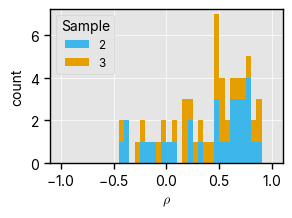

In [41]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman

with PaperStyle():

    joint_correlations = []
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    
    for m, mrt in enumerate(MRT):
        # fig, ax = plt.subplots(1, 1, figsize=(12,2))
        common_index = plrnn_emi_cir.loc[mrt].index.intersection(att.unstack('emi')['att'].loc[mrt].index)
        this_plrnn_emi_cir = plrnn_emi_cir.loc[mrt].loc[common_index]
        this_effects = att.unstack('emi')['att'].loc[mrt].loc[common_index]
        this_emi_occurrence = att.unstack('emi')['occurrence'].loc[mrt].loc[common_index]
        correlations = weight_corr_for_dataframes(this_plrnn_emi_cir, this_effects, this_emi_occurrence, method='spearman', axis=1, B=1000, alternative='greater', 
                                                  p_method='permutation', ci_type='percentile', clip_ci=True)
        joint_correlations.append(correlations['statistic'])
        correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
        participant_order = correlations.sort_values(by='statistic').dropna().index
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()

        if len(dropped) > 0:
            print(f'Dropped participants {dropped}.')
        print(f'MRT{mrt}, percent >0.5: {100*(correlations['statistic']>0.5).mean()}')
        print(f'      percent >0.3: {100*((correlations['statistic']>0.3) & (correlations['statistic']<=0.5)).mean()}')
        print(f'      percent >0.1: {100*((correlations['statistic']>0.1) & (correlations['statistic']<=0.3)).mean()}')

        # correlations.loc[participant_order, 'statistic'].plot(ax=ax, kind='bar', ylabel=r'$\rho$', rot=90, title=f'MRT{mrt}',
        #                                          color=correlations.loc[participant_order, 'signif_color'],
        #                                          yerr=[correlations.loc[participant_order, 'statistic']-correlations.loc[participant_order, 'ci_lower'],
        #                                                correlations.loc[participant_order, 'ci_upper']-correlations.loc[participant_order, 'statistic']])
        # plotting_utils.adjust_ylim(ax, 0.03, 0.03)
        # print(f'MRT{mrt}, percent >0: {100*(correlations['signif_color']=='C0'*1).mean()}')

        overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
        print(f'Group-wise correlation: {overall_effect['effect']:.3f}, 95% CI [{overall_effect['ci_lower']:.3f}, {overall_effect['ci_upper']:.3f}], p={overall_effect['p']:.3f}')
        
    joint_correlations = pd.concat(joint_correlations, axis=1, keys=MRT, names=['Sample']).astype(float)
    joint_correlations.plot(ax=ax, kind='hist', ylabel='count', xlabel=r'$\rho$', bins=np.arange(-1, 1.05, 0.05), stacked=True)
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.0)
    if SAVE:
            plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_diff_in_diff_histogram.svg'))
    plt.show()

Calculate Difference-in-differences matched average causal treatment effects (ATT) for EMIs in one pass

In [42]:
import sys
sys.path.append('..')
from tqdm import tqdm
import torch as tc
import pandas as pd
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN
from eval_reallabor.emi_did import did_match_all_emi, did_match_single_emi

MRT = [2, 3]
att_onepass = []

for mrt in MRT:

    mrt_att = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    errors = 0
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):
        df['score'] = df[LABELS].mean(axis=1)
        df['24h_score'] = df['score'].rolling(window=7, min_periods=1, center=False).mean()
        df['time'] = df['Time']
        df['daynr'] = df['DayNr']
        participant_att = []
        try:
            did_result = did_match_all_emi(df, INTERACTIVE_NAMES, method='propensity', k=3, caliper=None)
        except Exception as e:
            errors += 1
            continue
        participant_att = did_result.loc[did_result['n_matched_treated']>0, ['emi_col', 'att', 'n_matched_treated']]
        participant_att = participant_att.rename(columns={'emi_col': 'emi', 'n_matched_treated': 'occurrence'})
        participant_att['participant'] = p
        mrt_att.append(participant_att.set_index(['participant', 'emi']))
    mrt_att = pd.concat(mrt_att, axis=0)
    att_onepass.append(mrt_att)
att_onepass = pd.concat(att_onepass, keys=MRT, names=['mrt'])
att_onepass['att'] = att_onepass['att'].astype(np.float32)
att_onepass['occurrence'] = att_onepass['occurrence'].astype(int)

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [00:05<00:00,  9.99it/s]


Plot rank correlations for one-pass ATT

Dropped participants [12.0, 13.0, 14.0, 18.0, 22.0, 25.0, 27.0, 29.0, 55.0, 59.0, 61.0, 63.0, 66.0, 67.0, 68.0, 72.0, 74.0, 78.0, 79.0, 80.0, 82.0, 102.0].
MRT2, percent >0.5: 29.629629629629626
      percent >0.3: 5.555555555555555
      percent >0.1: 7.4074074074074066
Group-wise correlation: 0.606, 95% CI [0.499, 0.695], p=0.000
Dropped participants [203.0, 206.0, 209.0, 211.0, 212.0, 224.0, 226.0, 229.0, 231.0, 233.0, 234.0, 236.0, 237.0, 238.0, 242.0, 243.0, 254.0, 257.0, 258.0, 259.0, 260.0, 262.0, 263.0, 264.0, 266.0, 269.0, 270.0, 271.0, 301.0].
MRT3, percent >0.5: 17.24137931034483
      percent >0.3: 15.517241379310345
      percent >0.1: 8.620689655172415
Group-wise correlation: 0.499, 95% CI [0.367, 0.611], p=0.000


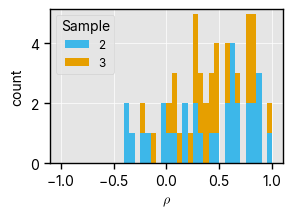

In [43]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman

with PaperStyle():

    joint_correlations = []
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    
    for m, mrt in enumerate(MRT):
        # fig, ax = plt.subplots(1, 1, figsize=(12,2))
        common_index = plrnn_emi_cir.loc[mrt].index.intersection(att_onepass.unstack('emi')['att'].loc[mrt].index)
        this_plrnn_emi_cir = plrnn_emi_cir.loc[mrt].loc[common_index]
        this_effects = att_onepass.unstack('emi')['att'].loc[mrt].loc[common_index]
        this_emi_occurrence = att_onepass.unstack('emi')['occurrence'].loc[mrt].loc[common_index]
        correlations = weight_corr_for_dataframes(this_plrnn_emi_cir, this_effects, this_emi_occurrence, method='spearman', axis=1, B=1000, alternative='greater', 
                                                  p_method='permutation', ci_type='percentile', clip_ci=True)
        joint_correlations.append(correlations['statistic'])
        correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
        participant_order = correlations.sort_values(by='statistic').dropna().index
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()

        if len(dropped) > 0:
            print(f'Dropped participants {dropped}.')
        print(f'MRT{mrt}, percent >0.5: {100*(correlations['statistic']>0.5).mean()}')
        print(f'      percent >0.3: {100*((correlations['statistic']>0.3) & (correlations['statistic']<=0.5)).mean()}')
        print(f'      percent >0.1: {100*((correlations['statistic']>0.1) & (correlations['statistic']<=0.3)).mean()}')

        # correlations.loc[participant_order, 'statistic'].plot(ax=ax, kind='bar', ylabel=r'$\rho$', rot=90, title=f'MRT{mrt}',
        #                                          color=correlations.loc[participant_order, 'signif_color'],
        #                                          yerr=[correlations.loc[participant_order, 'statistic']-correlations.loc[participant_order, 'ci_lower'],
        #                                                correlations.loc[participant_order, 'ci_upper']-correlations.loc[participant_order, 'statistic']])
        # plotting_utils.adjust_ylim(ax, 0.03, 0.03)
        # print(f'MRT{mrt}, percent >0: {100*(correlations['signif_color']=='C0'*1).mean()}')

        overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
        print(f'Group-wise correlation: {overall_effect['effect']:.3f}, 95% CI [{overall_effect['ci_lower']:.3f}, {overall_effect['ci_upper']:.3f}], p={overall_effect['p']:.3f}')
        
    joint_correlations = pd.concat(joint_correlations, axis=1, keys=MRT, names=['Sample']).astype(float)
    joint_correlations.plot(ax=ax, kind='hist', ylabel='count', xlabel=r'$\rho$', bins=np.arange(-1, 1.05, 0.05), stacked=True)
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.0)
    if SAVE:
            plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation_diff_in_diff_onepass_histogram.svg'))
    plt.show()

In [44]:
from eval_reallabor.emi_iptw import build_intervals_for_iptw, iptw_multiarm_msm, iptw_any_emi_with_type_mods

# 3) Any-EMI IPTW + type modifiers (Option 3)
# res3 = iptw_any_emi_with_type_mods(
#     inter, id_col="id",
#     ref_type=1,                # choose your treated reference type
#     weight_trunc=(0.01, 10),
#     include_covariates_in_outcome=False,
#     use_wls=True
# )

from tqdm import tqdm
import pandas as pd
import numpy as np
import data_utils
from plotting_styles import PaperStyle

MRT = [2, 3]
coef = []

for mrt in MRT:

    mrt_coef = []
    test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
    data_files = data_utils.get_data_files(test_data_dir)
    participants = data_utils.get_participant_ids(data_files)
    dist = {}
    errors = 0
    for p, df in tqdm(data_utils.zip_participants_data(test_data_dir), total=len(participants), desc=f'Calculating proximal effects for MRT {mrt}'):
        df['score'] = df[LABELS].mean(axis=1)
        df['24h_score'] = df['score'].rolling(window=7, min_periods=1, center=False).mean()
        df['time'] = df['Time']
        df['daynr'] = df['DayNr']
        participant_coef = []
        try:
            iptw_inter = build_intervals_for_iptw(df, interactive_cols=INTERACTIVE_NAMES)
            iptw_result = iptw_multiarm_msm(iptw_inter, id_col=None, weight_trunc=(0.01, 10), use_wls=True, wls_cov_type='HAC')
        except Exception as e:
            errors += 1
            continue
        participant_coef = iptw_result.coef.rename(columns={'type': 'emi', 'effect_vs_none': 'coef'})
        participant_coef = participant_coef.dropna()[['emi', 'coef']]
        participant_coef['emi'] = participant_coef['emi'].apply(lambda e: INTERACTIVE_NAMES[e-1])  # type indices start at 1
        participant_coef['participant'] = p
        participant_coef['occurrence'] = df[participant_coef['emi']].sum(axis=0).to_numpy()
        mrt_coef.append(participant_coef.set_index(['participant', 'emi']))
    mrt_coef = pd.concat(mrt_coef, axis=0)
    coef.append(mrt_coef)
coef = pd.concat(coef, keys=MRT, names=['mrt'])
coef['coef'] = coef['coef'].astype(np.float32)
# att['occurrence'] = att['occurrence'].astype(int)

Calculating proximal effects for MRT 3: 100%|██████████| 59/59 [00:00<00:00, 69.48it/s]


In [45]:
coef.groupby(['emi']).apply(weighted_group_test, 'coef', 'occurrence')

,mean,se,ci95_low,ci95_high,t,p,N,N_eff
emi,,,,,,,,
interactive1,0.069517,0.047575,-0.023731,0.162764,1.461199,0.148142,109.0,75.935233
interactive2,0.037042,0.039791,-0.040949,0.115033,0.930915,0.355045,107.0,72.153964
interactive3,0.111785,0.043358,0.026804,0.196767,2.578195,0.012017,104.0,71.660254
interactive4,0.005969,0.039314,-0.071087,0.083024,0.151817,0.879736,103.0,76.508884
interactive5,-0.025911,0.050841,-0.125559,0.073738,-0.509638,0.611787,101.0,76.727160
interactive6,0.054635,0.059310,-0.061612,0.170881,0.921179,0.360247,98.0,68.296155
interactive7,0.043279,0.044085,-0.043128,0.129686,0.981702,0.329840,94.0,66.848246
interactive8,0.050532,0.047573,-0.042712,0.143776,1.062192,0.292028,95.0,66.853413


Dropped participants [12.0, 13.0, 18.0, 22.0, 25.0, 27.0, 29.0, 55.0, 63.0, 67.0, 68.0, 72.0, 74.0, 78.0, 79.0, 80.0, 82.0, 102.0].
MRT2, percent >0.5: 29.629629629629626
      percent >0.3: 11.11111111111111
      percent >0.1: 16.666666666666664
Group-wise correlation: 0.502, 95% CI [0.385, 0.603], p=0.000
Dropped participants [206.0, 209.0, 224.0, 226.0, 231.0, 234.0, 237.0, 243.0, 254.0, 257.0, 258.0, 259.0, 260.0, 262.0, 263.0, 264.0, 266.0, 269.0, 271.0, 301.0].
MRT3, percent >0.5: 22.413793103448278
      percent >0.3: 12.068965517241379
      percent >0.1: 15.517241379310345
Group-wise correlation: 0.372, 95% CI [0.243, 0.487], p=0.000


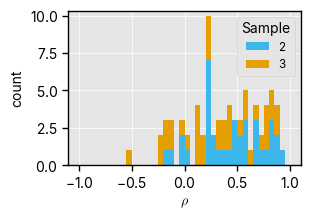

In [46]:
import sys
sys.path.append('..')
import pandas as pd
import torch as tc
from scipy.stats import kendalltau, spearmanr
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle
import plotting_utils
from weighted_correlation import weight_corr_for_dataframes, meta_spearman

with PaperStyle():

    joint_correlations = []
    fig, ax = plt.subplots(1, 1, figsize=(3,2))
    
    for m, mrt in enumerate(MRT):
        # fig, ax = plt.subplots(1, 1, figsize=(12,2))
        common_index = plrnn_emi_cir.loc[mrt].index.intersection(coef.unstack('emi')['coef'].loc[mrt].index)
        this_plrnn_emi_cir = plrnn_emi_cir.loc[mrt].loc[common_index]
        this_effects = coef.unstack('emi')['coef'].loc[mrt].loc[common_index]
        this_emi_occurrence = coef.unstack('emi')['occurrence'].loc[mrt].loc[common_index]
        correlations = weight_corr_for_dataframes(this_plrnn_emi_cir, this_effects, this_emi_occurrence, method='spearman', axis=1, B=1000, alternative='greater', 
                                                  p_method='permutation', ci_type='percentile', clip_ci=True)
        joint_correlations.append(correlations['statistic'])
        correlations['signif_color'] = correlations['p_value'].apply(lambda p: 'C0' if p<0.05 else 'C1')
        participant_order = correlations.sort_values(by='statistic').dropna().index
        dropped = correlations.loc[correlations['statistic'].isna()].index.to_list()

        if len(dropped) > 0:
            print(f'Dropped participants {dropped}.')
        print(f'MRT{mrt}, percent >0.5: {100*(correlations['statistic']>0.5).mean()}')
        print(f'      percent >0.3: {100*((correlations['statistic']>0.3) & (correlations['statistic']<=0.5)).mean()}')
        print(f'      percent >0.1: {100*((correlations['statistic']>0.1) & (correlations['statistic']<=0.3)).mean()}')

        # correlations.loc[participant_order, 'statistic'].plot(ax=ax, kind='bar', ylabel=r'$\rho$', rot=90, title=f'MRT{mrt}',
        #                                          color=correlations.loc[participant_order, 'signif_color'],
        #                                          yerr=[correlations.loc[participant_order, 'statistic']-correlations.loc[participant_order, 'ci_lower'],
        #                                                correlations.loc[participant_order, 'ci_upper']-correlations.loc[participant_order, 'statistic']])
        # plotting_utils.adjust_ylim(ax, 0.03, 0.03)
        # print(f'MRT{mrt}, percent >0: {100*(correlations['signif_color']=='C0'*1).mean()}')

        overall_effect = meta_spearman(correlations['statistic'].dropna(), None)
        print(f'Group-wise correlation: {overall_effect['effect']:.3f}, 95% CI [{overall_effect['ci_lower']:.3f}, {overall_effect['ci_upper']:.3f}], p={overall_effect['p']:.3f}')
        
    joint_correlations = pd.concat(joint_correlations, axis=1, keys=MRT, names=['Sample']).astype(float)
    joint_correlations.plot(ax=ax, kind='hist', ylabel='count', xlabel=r'$\rho$', bins=np.arange(-1, 1.05, 0.05), stacked=True)
    plotting_utils.adjust_ylim(ax, top=0.03, bottom=0.0)
    if SAVE:
            plt.savefig(data_utils.join_ordinal_bptt_path('results', '_paper', f'emi_rank_correlation__iptw_histogram.svg'))
    plt.show()